In [1]:
#import sys
#!{sys.executable} -m pip install -U scikit-learn
#!pip install graphviz
#!pip install pydot
#!winget install --id Graphviz.Graphviz -e


In [2]:
import os
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"
!dot -V

dot - graphviz version 14.1.1 (20251213.1925)


In [3]:
import shutil
shutil.which("dot")

'C:\\Program Files\\Graphviz\\bin\\dot.EXE'

In [4]:
from IPython.display import Image, display

### Trabalha dados de uma loja de veículos

In [5]:
import pandas as pd

dados = pd.read_csv("machine-learning-carros-simulacao_local.csv")
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [6]:
dados.shape[0]
# ou: len(dados)

10000

In [7]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
10,75668.42,0,2,22635.36710
7,65265.09,0,10,18666.73466
3,95276.14,0,3,43167.32682
2,89627.50,0,12,11440.79806
4221,64724.65,0,10,13194.97866


**DummyClassifier (scikit-learn)** = baseline de classificação: **não aprende** padrões, só segue regras simples.  
Serve para comparar: se seu modelo não supera o dummy, algo está errado.  
Principais `strategy`:  
- `most_frequent`: sempre prevê a classe mais comum.  
- `prior/stratified`: sorteia seguindo a distribuição das classes no treino.  
- `uniform`: sorteio totalmente uniforme.  
- `constant`: sempre prevê uma classe fixa (`constant=...`).  
Avalie com `cross_validate` e métricas como `f1`/`balanced_accuracy` (accuracy pode enganar). 

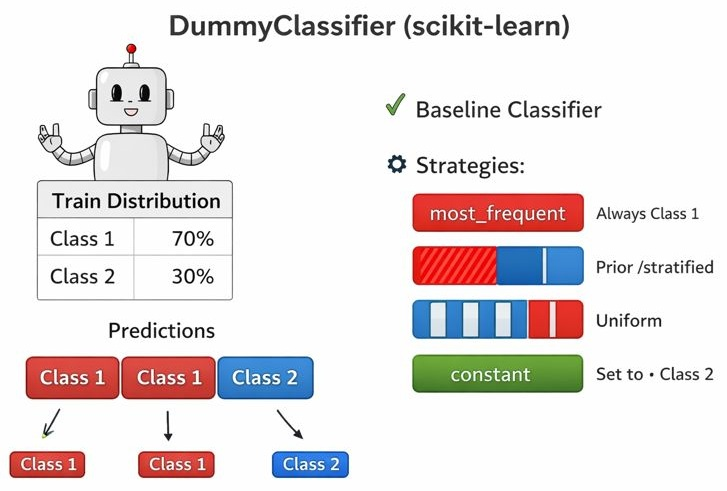

In [8]:
display(Image(filename="DummyClassifier.png"))

**`cross_validate` (scikit-learn)** executa **validação cruzada** para estimar desempenho do modelo.  
Ele divide os dados em `cv` partes (*folds*): treina em `cv-1` e testa na parte restante, repetindo.  
Retorna um **dicionário** com métricas por fold (ex.: `test_accuracy`, `test_f1`, etc.).  
Você escolhe as métricas em `scoring` (uma ou várias).  
Também pode retornar tempos: `fit_time` e `score_time`.  
Útil para comparar modelos de forma mais confiável do que um único split treino/teste.  
Ex.: `cross_validate(model, X, y, cv=5, scoring=["accuracy","f1"])`.  

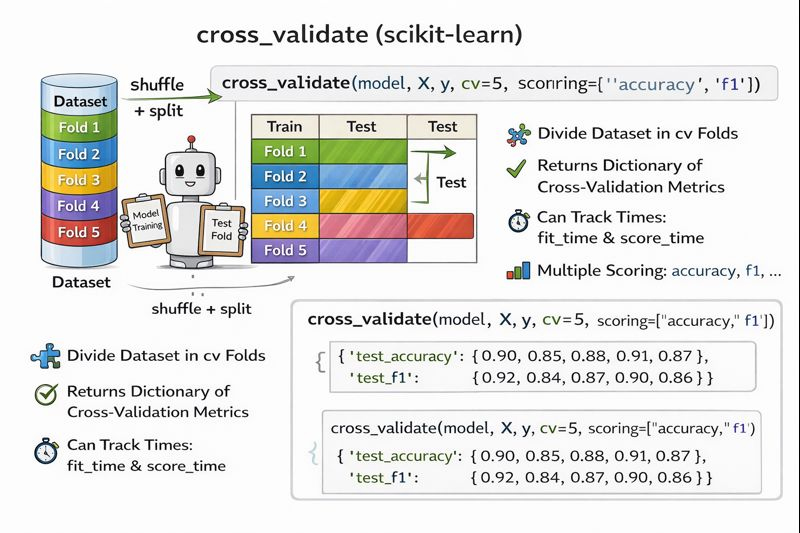

In [9]:
display(Image(filename="cross_validate.jpg"))

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


**DecisionTreeClassifier (scikit-learn)** = modelo de classificação que aprende **regras “se… então…”** dividindo os dados em nós.  
Cada divisão escolhe uma feature/limiar para **reduzir impureza** (ex.: `gini` ou `entropy`).  
Vantagens: simples de entender, aceita dados não lineares, pouca preparação (sem escala obrigatória).  
Riscos: **overfitting** se crescer demais (memoriza o treino).  
Principais controles: `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`.  
Avalie com validação cruzada (`cross_validate`) e compare com um baseline (ex.: DummyClassifier).  

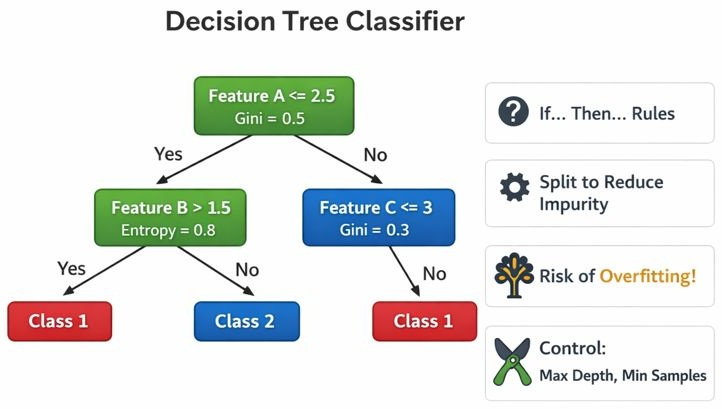

In [11]:
display(Image(filename="DecisionTreeClassifier.png"))

In [12]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.26, 78.30]


In [13]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [14]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [15]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.79
Intervalo [74.03, 77.56]


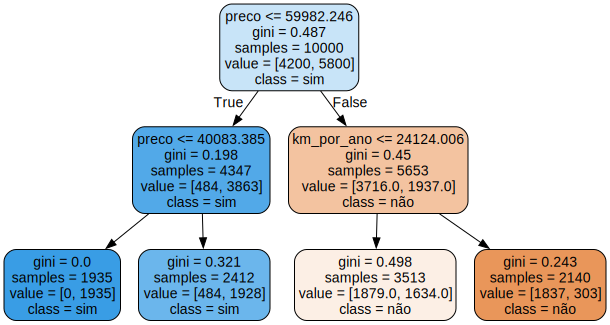

In [16]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
# Visualizando a árvore de decisão

from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [21]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
# agora com max_depth = 3
#from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.66
Intervalo [77.21, 80.12]


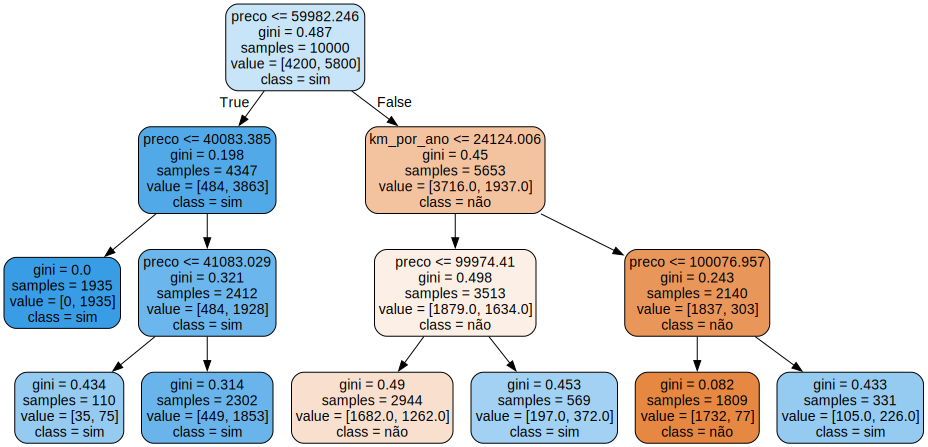

In [22]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
# Visualizando a árvore de decisão

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names = features)
graph = graphviz.Source(dot_data)
graph

**SVC (scikit-learn)** = *Support Vector Classifier*, classificador baseado em **SVM**.  
Ele procura um **hiperplano** que separa as classes com a **maior margem** possível.  
Funciona muito bem em alta dimensão e com limites complexos usando **kernels**.  
Principais `kernel`: `linear`, `rbf` (padrão), `poly`, `sigmoid`.  
`C` controla regularização: **C alto** = menos margem/mais overfitting; **C baixo** = mais margem/mais generalização.  
Para `rbf`, `gamma` controla a “curvatura” da fronteira (alto = mais complexo).  
Recomenda-se **padronizar** features (`StandardScaler`) antes de treinar.  
`probability=True` permite `predict_proba`, mas deixa o treino mais lento.  

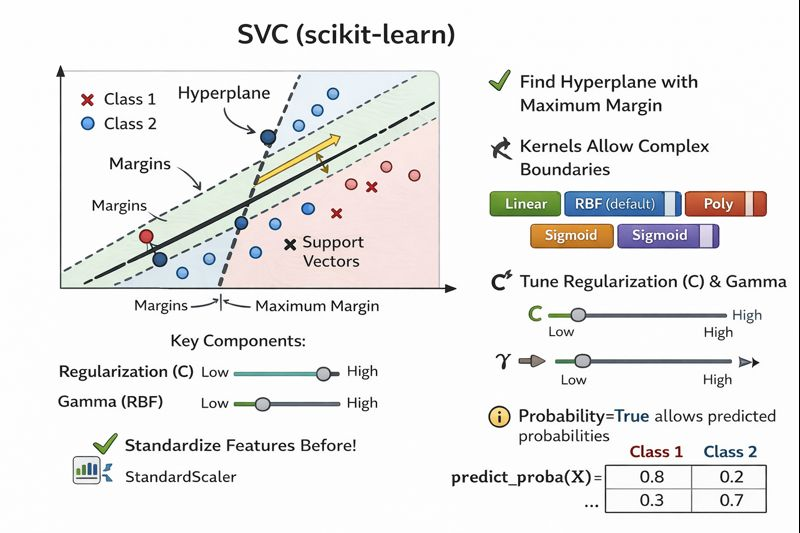

In [17]:
display(Image(filename="SVC.png"))

In [18]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.62
Intervalo [74.02, 79.22]
